# (7주차) 10월18일 
> 이미지자료분석-- CNN 예비학습, CNN 구현 (CPU), CNN 구현 (GPU), BCEWithLogisticLoss

- toc:true
- branch: master
- badges: true
- comments: true
- author: 최규빈

## 강의영상 

> https://youtube.com/playlist?list=PLQqh36zP38-ymnoeGZPPvaaB35JmhRiTi

## import 

In [1]:
import torch 
import torchvision
from fastai.vision.all import * 
import time

In [2]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }');

In [3]:
#hide
graphviz.set_jupyter_format('png')

'svg'

## data 

`-` download data 

In [4]:
path = untar_data(URLs.MNIST)

`-` training set 

In [5]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

`-` test set 

In [6]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255
yy = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [7]:
X.shape,XX.shape,y.shape,yy.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([2115, 1, 28, 28]),
 torch.Size([12665, 1]),
 torch.Size([2115, 1]))

## CNN 예비학습

### 기존의 MLP 모형 

`-` 교재의 모형 

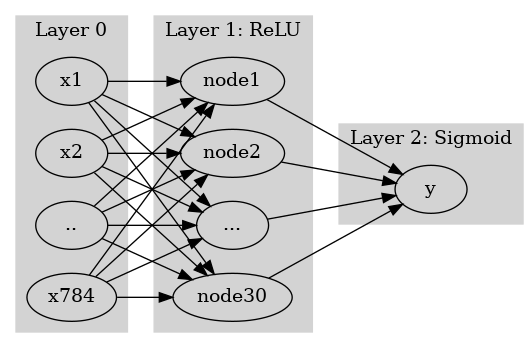

In [127]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node30" -> "y"
    label = "Layer 2: Sigmoid"
}
''')

`-` 왜 28$\times$28 이미지를 784개의 벡터로 만든 다음에 모형을 돌려야 하는가? 

`-` 기존에 개발된 모형이 회귀분석 기반으로 되어있어서 결국 회귀분석 틀에 짜 맞추어서 이미지자료를 분석하는 느낌 

`-` observation의 차원은 $784$가 아니라 $1\times (28\times 28)$이 되어야 맞다. 

### 새로운 아키텍처의 제시

`-` 예전

$\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$  

- $l_1$: 선형변환, feature를 뻥튀기하는 역할 
- $relu$: 뻥튀기된 feature에 비선형을 추가하여 표현력 극대화 
- $l_2$: 선형변환, 뻥튀기된 feature를 요약 하는 역할 (=데이터를 요약하는 역할) 

`-` 새로운 아키텍처 
- $conv$: feature를 뻥튀기하는 역할 (2d ver $l_1$ 느낌) 
- $relu$: 
- $pooling$: 데이터를 요약하는 역할 

### CONV 레이어 (선형변환의 2D 버전) 

`-` 우선 연산하는 방법만 살펴보자. 

**(예시1)**

In [73]:
torch.manual_seed(43052)
_conv = torch.nn.Conv2d(1,1,(2,2)) # 입력1, 출력1, (2,2) window size
_conv.weight.data, _conv.bias.data

(tensor([[[[-0.1733, -0.4235],
           [ 0.1802,  0.4668]]]]),
 tensor([0.2037]))

In [74]:
_X = torch.arange(0,4).reshape(1,2,2).float()
_X

tensor([[[0., 1.],
         [2., 3.]]])

In [16]:
(-0.1733)*0 + (-0.4235)*1 +\
(0.1802)*2 + (0.4668)*3 + 0.2037

1.541

In [17]:
_conv(_X)

tensor([[[1.5410]]], grad_fn=<SqueezeBackward1>)

**(예시2) 잘하면 평균도 계산하겠다?**

In [18]:
_conv.weight.data = torch.tensor([[[[1/4, 1/4],[1/4,1/4]]]])
_conv.bias.data = torch.tensor([0.0])

In [20]:
_conv(_X) , (0+1+2+3)/4

(tensor([[[1.5000]]], grad_fn=<SqueezeBackward1>), 1.5)

**(예시3) 이동평균?**

In [21]:
_X = torch.arange(0,25).float().reshape(1,5,5) 
_X

tensor([[[ 0.,  1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.,  9.],
         [10., 11., 12., 13., 14.],
         [15., 16., 17., 18., 19.],
         [20., 21., 22., 23., 24.]]])

In [23]:
_conv(_X)

tensor([[[ 3.,  4.,  5.,  6.],
         [ 8.,  9., 10., 11.],
         [13., 14., 15., 16.],
         [18., 19., 20., 21.]]], grad_fn=<SqueezeBackward1>)

**(예시4) window size가 증가한다면? (2d의 이동평균느낌)**

In [28]:
_conv = torch.nn.Conv2d(1,1,(3,3)) # 입력1, 출력1, (3,3) window size
_conv.bias.data = torch.tensor([0.0])
_conv.weight.data = torch.tensor([[[[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]]]])

In [31]:
_X,_conv(_X)

(tensor([[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]]),
 tensor([[[ 6.0000,  7.0000,  8.0000],
          [11.0000, 12.0000, 13.0000],
          [16.0000, 17.0000, 18.0000]]], grad_fn=<SqueezeBackward1>))

In [33]:
(1+2+3+6+7+8+11+12+13)/9

7.0

**(예시5) 피처뻥튀기**

In [37]:
_X = torch.tensor([1.0,1.0,1.0,1.0]).reshape(1,2,2)
_X

tensor([[[1., 1.],
         [1., 1.]]])

In [41]:
_conv = torch.nn.Conv2d(1,8,(2,2))
_conv.weight.data.shape,_conv.bias.data.shape

(torch.Size([8, 1, 2, 2]), torch.Size([8]))

In [45]:
_conv(_X).reshape(-1)

tensor([ 0.4362,  1.5645,  0.4842,  0.2747, -0.2649,  0.5932, -0.4352, -0.4932],
       grad_fn=<ReshapeAliasBackward0>)

In [55]:
torch.sum(_conv.weight.data[0,...])+_conv.bias.data[0],\
torch.sum(_conv.weight.data[1,...])+_conv.bias.data[1]

(tensor(0.4362), tensor(1.5645))

결국 

In [63]:
torch.sum(_conv.weight.data,axis=(2,3)).reshape(-1)+ _conv.bias.data

tensor([ 0.4362,  1.5645,  0.4842,  0.2747, -0.2649,  0.5932, -0.4352, -0.4932])

In [65]:
_conv(_X).reshape(-1)

tensor([ 0.4362,  1.5645,  0.4842,  0.2747, -0.2649,  0.5932, -0.4352, -0.4932],
       grad_fn=<ReshapeAliasBackward0>)

***(잔소리) axis 사용 익숙하지 않으면 아래 꼭 들으세요..***

- https://guebin.github.io/IP2022/2022/04/11/(6주차)-4월11일.html , numpy공부 4단계: 축

### ReLU (2d)

In [68]:
_X = torch.randn(25).reshape(1,5,5)
_X

tensor([[[ 0.0118, -0.7161, -1.7477,  2.3146,  1.8004],
         [-0.5411, -1.1889,  0.1238,  0.5273,  0.1966],
         [ 1.1332, -1.6745, -0.2016, -1.5012,  1.4287],
         [ 0.7716, -0.8989,  0.7226,  0.4020, -0.4857],
         [-1.1466,  0.9694, -1.0111,  0.2031,  1.4473]]])

In [69]:
a1=torch.nn.ReLU()

In [70]:
a1(_X)

tensor([[[0.0118, 0.0000, 0.0000, 2.3146, 1.8004],
         [0.0000, 0.0000, 0.1238, 0.5273, 0.1966],
         [1.1332, 0.0000, 0.0000, 0.0000, 1.4287],
         [0.7716, 0.0000, 0.7226, 0.4020, 0.0000],
         [0.0000, 0.9694, 0.0000, 0.2031, 1.4473]]])

### Maxpooling 레이어

In [86]:
_maxpooling = torch.nn.MaxPool2d((2,2))

In [87]:
_X = torch.arange(16).float().reshape(1,4,4) 

In [88]:
_X, _maxpooling(_X) 

(tensor([[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]),
 tensor([[[ 5.,  7.],
          [13., 15.]]]))

In [89]:
_X = torch.arange(25).float().reshape(1,5,5) 

In [90]:
_X, _maxpooling(_X) 

(tensor([[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]]),
 tensor([[[ 6.,  8.],
          [16., 18.]]]))

In [91]:
_X = torch.arange(36).float().reshape(1,6,6) 

In [92]:
_X, _maxpooling(_X) 

(tensor([[[ 0.,  1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10., 11.],
          [12., 13., 14., 15., 16., 17.],
          [18., 19., 20., 21., 22., 23.],
          [24., 25., 26., 27., 28., 29.],
          [30., 31., 32., 33., 34., 35.]]]),
 tensor([[[ 7.,  9., 11.],
          [19., 21., 23.],
          [31., 33., 35.]]]))

## CNN 구현 (CPU)

In [99]:
X.shape

torch.Size([12665, 1, 28, 28])

### (1) Conv2d

In [103]:
c1 = torch.nn.Conv2d(1,16,(5,5))
print(X.shape)
print(c1(X).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])


### (2) ReLU

In [104]:
a1 = torch.nn.ReLU()
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])


### (3) MaxPool2D

In [106]:
m1 =  torch.nn.MaxPool2d((2,2)) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])


### (4) 적당히 마무리하고 시그모이드 태우자 

`-` 펼치자. 

(방법1)

In [111]:
m1(a1(c1(X))).reshape(-1,2304).shape

torch.Size([12665, 2304])

In [108]:
16*12*12 

2304

(방법2)

In [113]:
flttn = torch.nn.Flatten()

In [117]:
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])


`-` 2304 $\to$ 1 로 차원축소하는 선형레이어를 설계

In [119]:
l1 = torch.nn.Linear(in_features=2304,out_features=1) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)
print(l1(flttn(m1(a1(c1(X))))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])
torch.Size([12665, 1])


`-` 시그모이드

In [120]:
a2 = torch.nn.Sigmoid()

In [121]:
l1 = torch.nn.Linear(in_features=2304,out_features=1) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)
print(l1(flttn(m1(a1(c1(X))))).shape)
print(a1(l1(flttn(m1(a1(c1(X)))))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])
torch.Size([12665, 1])
torch.Size([12665, 1])


`-` 네트워크 설계

In [148]:
net = torch.nn.Sequential(
    c1, # 2d: 컨볼루션(선형변환), 피처 뻥튀기 
    a1, # 2d: 렐루(비선형변환)
    m1, # 2d: 맥스풀링: 데이터요약
    flttn, # 2d->1d 
    l1, # 1d: 선형변환
    a2 # 1d: 시그모이드(비선형변환) 
)

In [146]:
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

In [147]:
t1= time.time()
for epoc in range(100): 
    ## 1
    yhat = net(X) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()
t2= time.time()
t2-t1

51.21047353744507

Text(0.5, 1.0, 'Traning Set')

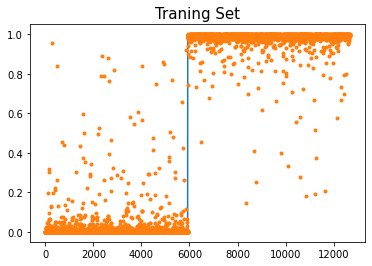

In [151]:
plt.plot(y)
plt.plot(net(X).data,'.')
plt.title('Traning Set',size=15)

Text(0.5, 1.0, 'Test Set')

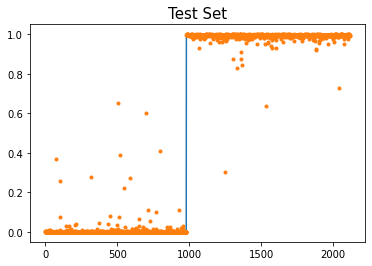

In [152]:
plt.plot(yy)
plt.plot(net(XX).data,'.')
plt.title('Test Set',size=15)

## CNN 구현 (GPU)

### 1. dls

In [160]:
ds1=torch.utils.data.TensorDataset(X,y)
ds2=torch.utils.data.TensorDataset(XX,yy)

In [161]:
X.shape

torch.Size([12665, 1, 28, 28])

In [162]:
len(X)/10

1266.5

In [163]:
len(XX)

2115

In [164]:
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 

In [165]:
dls = DataLoaders(dl1,dl2) # 이거 fastai 지원함수입니다

### 2. lrnr 생성: 아키텍처, 손실함수, 옵티마이저 

In [173]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()

In [174]:
lrnr = Learner(dls,net,loss_fn)

### 3. 학습

In [175]:
lrnr.fit(10) 

epoch,train_loss,valid_loss,time
0,0.854868,0.605624,00:00
1,0.661470,0.395755,00:00
2,0.514805,0.216046,00:00
3,0.395138,0.105544,00:00
4,0.303009,0.056478,00:00
5,0.235024,0.035678,00:00
6,0.184949,0.025611,00:00
7,0.147473,0.019807,00:00
8,0.118915,0.016009,00:00
9,0.096791,0.013305,00:00


### 4. 예측 및 시각화 

In [183]:
net.to("cpu") 

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

`-` 결과를 시각화하면 아래와 같다. 

Text(0.5, 1.0, 'Training Set')

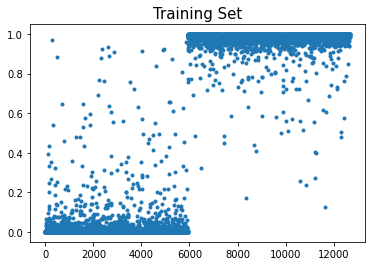

In [185]:
plt.plot(net(X).data,'.')
plt.title("Training Set",size=15)

Text(0.5, 1.0, 'Test Set')

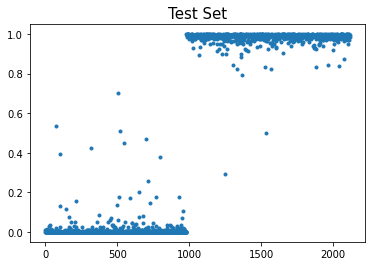

In [186]:
plt.plot(net(XX).data,'.')
plt.title("Test Set",size=15)

`-` 빠르고 적합결과도 좋음 

### Lrnr 오브젝트

In [188]:
lrnr.model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

In [189]:
net

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

In [190]:
id(lrnr.model), id(net)

(140201183587664, 140201183587664)

In [191]:
lrnr.model(X)

tensor([[2.9607e-03],
        [2.2451e-04],
        [1.6204e-03],
        ...,
        [9.9787e-01],
        [9.9764e-01],
        [9.9820e-01]], grad_fn=<SigmoidBackward0>)

### BCEWithLogitsLoss

`-` BCEWithLogitsLoss = Sigmoid + BCELoss
- 왜 써요? 수치적으로 더 안정 

`-` 사용방법

(1) dls 만들기 

In [193]:
ds1=torch.utils.data.TensorDataset(X,y)
ds2=torch.utils.data.TensorDataset(XX,yy)

In [194]:
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 

In [195]:
dls = DataLoaders(dl1,dl2) # 이거 fastai 지원함수입니다

(2) lrnr생성 

In [198]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    #torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCEWithLogitsLoss()
lrnr = Learner(dls,net,loss_fn) 

(3) 학습

In [199]:
lrnr.fit(10)

epoch,train_loss,valid_loss,time
0,1.003931,0.648003,00:00
1,0.704832,0.424581,00:00
2,0.562051,0.278943,00:00
3,0.452736,0.156993,00:00
4,0.358476,0.094420,00:00
5,0.284055,0.061440,00:00
6,0.227156,0.043418,00:00
7,0.183548,0.032584,00:00
8,0.149613,0.025527,00:00
9,0.122840,0.020648,00:00


(4) 예측 및 시각화

In [200]:
net.to("cpu")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
)

Text(0.5, 0.98, 'Training Set')

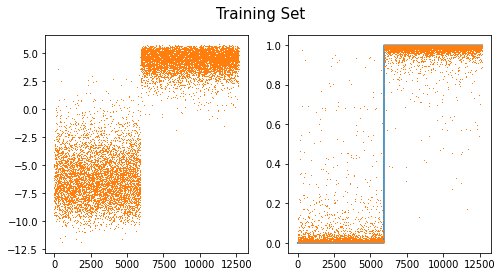

In [206]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(X).data,',',color="C1")
ax[1].plot(y)
ax[1].plot(a2(net(X)).data,',')
fig.suptitle("Training Set",size=15)

Text(0.5, 0.98, 'Test Set')

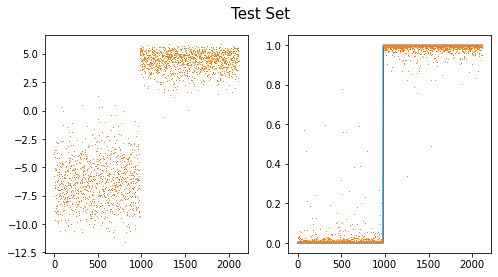

In [207]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(XX).data,',',color="C1")
ax[1].plot(yy)
ax[1].plot(a2(net(XX)).data,',')
fig.suptitle("Test Set",size=15)

### CrossEntropyLoss

`-` CrossEntropyLoss = Softmax + CrossEntropyLoss // 따라서 엄밀하게는 CEWithSoftmaxLoss 정도로 써야 맞음 
- 왜 써요? 다차원으로 확장이 용이

`-` 사용방법

(1) dls 만들기 

(2) lrnr생성 

(3) 학습

(4) 예측 및 시각화

Text(0.5, 0.98, 'Training Set')

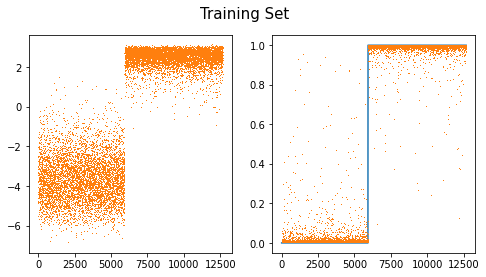

In [537]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(X)[:,1].data,',',color="C1")
ax[1].plot(y)
ax[1].plot(sftmax(net(X))[:,1].data,',')
fig.suptitle("Training Set",size=15)

Text(0.5, 0.98, 'Test Set')

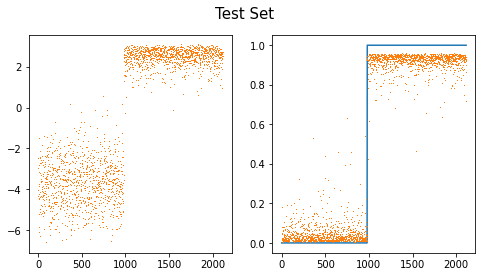

In [538]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(XX)[:,1].data,',',color="C1")
ax[1].plot(yy)
ax[1].plot(a2(net(XX))[:,1].data,',')
fig.suptitle("Test Set",size=15)

## Appendix 

### `A1`. 소프트맥스 vs 시그모이드 

(예비학습)

아래는 사실상 같은 네트워크라고 봐도 무방하다. 

(1) $\hat{y}_i = \hat{\beta}_0 +\hat{\beta}_1x_i$

(2) $\hat{y}_i = \hat{\beta}_0 + (\hat{\alpha}_1+\hat{\beta}_1) x_i$

(3) $\hat{y}_i = \hat{\alpha}_0+\hat{\beta}_0 +\hat{\beta}_1x_i$

(4) $\hat{y}_i = \hat{\alpha}_0+\hat{\beta}_0 +(\hat{\alpha}_1+\hat{\beta}_1)x_i$

네트워크의 표현력은 (1)과 동일함. 즉 (2)-(4)는 사실상 (1)과 동일한 아키텍처를 기술한 것임. 그런데 학습할 파라메터만 많은 꼴. 

`-` 시그모이드 

- y의 형태: 고양이=0, 개=1 

- 마지막 활성화함수: $u \to \frac{e^u}{1+e^u}$ 이때 $u$는 시그모이드층의 인풋 (=마지막 리니어층의 아웃풋)

- $u$의 값이 클수록 dog

`-` 소프트맥스 

- $y$의 형태: 고양이=[1,0], 개=[0,1] 

- 마지막 활성화함수: $(u_1,u_2) \to \big(\frac{e^{u_1}}{e^{u_1}+e^{u_2}},\frac{e^{u_2}}{e^{u_1}+e^{u_2}} \big)$, 이때 $(u_1,u_2)$는 소프트맥스의 인풋 (=마지막 리니어층의 아웃풋)

- $u_1$의 값이 클수록 cat, $u_2$의 값이 클수록 dog 

`-` 참고로 $\big(\frac{e^{u_1}}{e^{u_1}+e^{u_2}},\frac{e^{u_2}}{e^{u_1}+e^{u_2}} \big)$에서 분자분모에 각각 $e^{-u_1}$을 곱하면

$$\big(\frac{1}{1+e^{u_2-u_1}},\frac{e^{u_2-u_1}}{1+e^{u_2-u_1}} \big)$$

그리고 $u_2-u_1=u$라고 생각하면 

$$\big(\frac{1}{1+e^{u}},\frac{e^{u}}{1+e^{u}} \big)$$

이므로, 강아지라고 생각할 확률은 $\frac{e^u}{1+e^u}$, 고양이라고 생각할 확률은 $1-\frac{e^u}{1+e^u}$이 되므로 마지막 활성화 함수를 $u \to \frac{e^u}{1+e^u}$ 시그모이드와 같아진다.

`-`  결국 아래의 두 네트워크는 사실상 같은 네트워크임 (두 네트워크는 사실상 동일한 아키텍처를 기술하는 것임) 

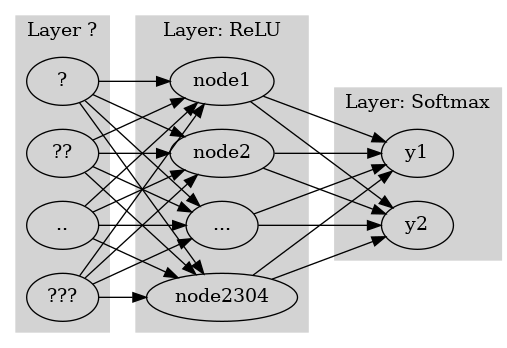

In [555]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "?"
    "??"
    ".."
    "???"
    label = "Layer ?"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "?" -> "node1"
    "??" -> "node1"
    ".." -> "node1"
    "???" -> "node1"
    
    "?" -> "node2"
    "??" -> "node2"
    ".." -> "node2"
    "???" -> "node2"
    
    "?" -> "..."
    "??" -> "..."
    ".." -> "..."
    "???" -> "..."
    
    "?" -> "node2304"
    "??" -> "node2304"
    ".." -> "node2304"
    "???" -> "node2304"

    label = "Layer: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y1"
    "node2" -> "y1"
    "..." -> "y1"
    "node2304" -> "y1"
    
    "node1" -> "y2"
    "node2" -> "y2"
    "..." -> "y2"
    "node2304" -> "y2"    
    label = "Layer: Softmax"
}
''')

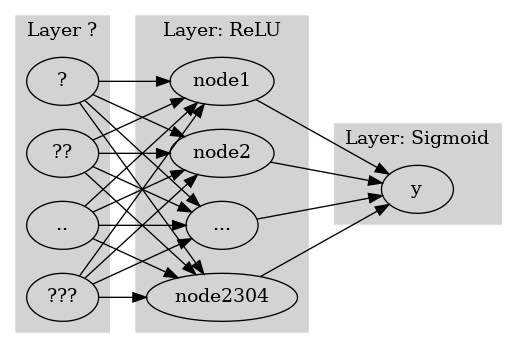

In [556]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "?"
    "??"
    ".."
    "???"
    label = "Layer ?"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "?" -> "node1"
    "??" -> "node1"
    ".." -> "node1"
    "???" -> "node1"
    
    "?" -> "node2"
    "??" -> "node2"
    ".." -> "node2"
    "???" -> "node2"
    
    "?" -> "..."
    "??" -> "..."
    ".." -> "..."
    "???" -> "..."
    
    "?" -> "node2304"
    "??" -> "node2304"
    ".." -> "node2304"
    "???" -> "node2304"

    label = "Layer: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node2304" -> "y"
    label = "Layer: Sigmoid"
}
''')

`-` 엄밀히 따지면 이는 파라메터의 낭비임. 하지만 Softmax를 생각하는 것은 다차원 카테고리로 확장이 용이하기 때문임. 만약에 개,고양이,사자를 구분해야하는 문제가 나온다면 sigmoid는 표현이 애매해지지만 softmax는 가능함.

`-` 결론 
1. 소프트맥스는 시그모이드의 확장이다. 
2. 클래스의 수가 2개일 경우에는 (Sigmoid, BCEloss) 조합을 사용해야 하고 클래스의 수가 2개보다 클 경우에는 (Softmax, CrossEntropyLoss) 를 사용해야 한다. 


`-` 그런데 사실.. 
1. 클래스의 수가 2개일 경우일때 (Softmax, CrossEntropyLoss)를 사용해도 그렇게 큰일나는것은 아니다. (흑백이미지를 칼라잉크로 출력하는 느낌) 
2. 실제로 클래스의 수가 2개일때 (Softmax, CrossEntropyLoss)를 많이 사용 (왜? transfer learning)


***참고***

|$y$|분포가정|마지막층의 활성화함수|손실함수(파이토치)|
|:--:|:--:|:--:|:--:|
|3.45, 4.43, ... (연속형) |정규분포|Linear|MSEloss|
|0 or 1|이항분포(베르누이)|Sigmoid| BCEloss|
|[0,0,1], [0,1,0], [1,0,0]| 다항분포|Softmax| CrossEntropyLoss|